In [1]:
import os
import numpy as np
import pandas as pd
import re
import json
from scipy.stats import wilcoxon
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns
from config import survpath, survscpath, phecatpath, temppath, numericpath

In [2]:
full=np.load(survpath+'610_0.npy')
phecat=np.load(phecatpath,allow_pickle=1)[0]

In [3]:
singledictionary = {}
def loadsingle(path):
    for key, content in phecat.items():
        singledictionary[key] = np.load(path + f'6{key}.npy')
loadsingle(survscpath)
alldictionary = {}
for key, content in phecat.items():
    alldictionary[key] = full[content]
sortdictionary = {}
for key, content in phecat.items():
    sortdictionary[key] = np.nanmean(alldictionary[key]) + np.nanmean(singledictionary[key])

In [4]:
index = np.argsort(np.array(list(sortdictionary.values())))
keywords = np.array(list(sortdictionary.keys()))[index]

In [5]:
pvalue = []
for skey in keywords:
    s = singledictionary[skey]
    a = alldictionary[skey]
    _, p = wilcoxon(s[~np.isnan(s)], a[~np.isnan(a)], alternative="two-sided")
    pvalue.append(p)

In [6]:
data = []
hue = []
group = []
for i, skey in enumerate(keywords):
    data += list(singledictionary[skey])
    data += list(alldictionary[skey])
    hue += [0] * len(singledictionary[skey])
    hue += [1] * len(alldictionary[skey])
    group += [i] * len(singledictionary[skey])
    group += [i] * len(alldictionary[skey])
    
drawdata = pd.DataFrame({'data':data, 'hue':hue, 'group':group})

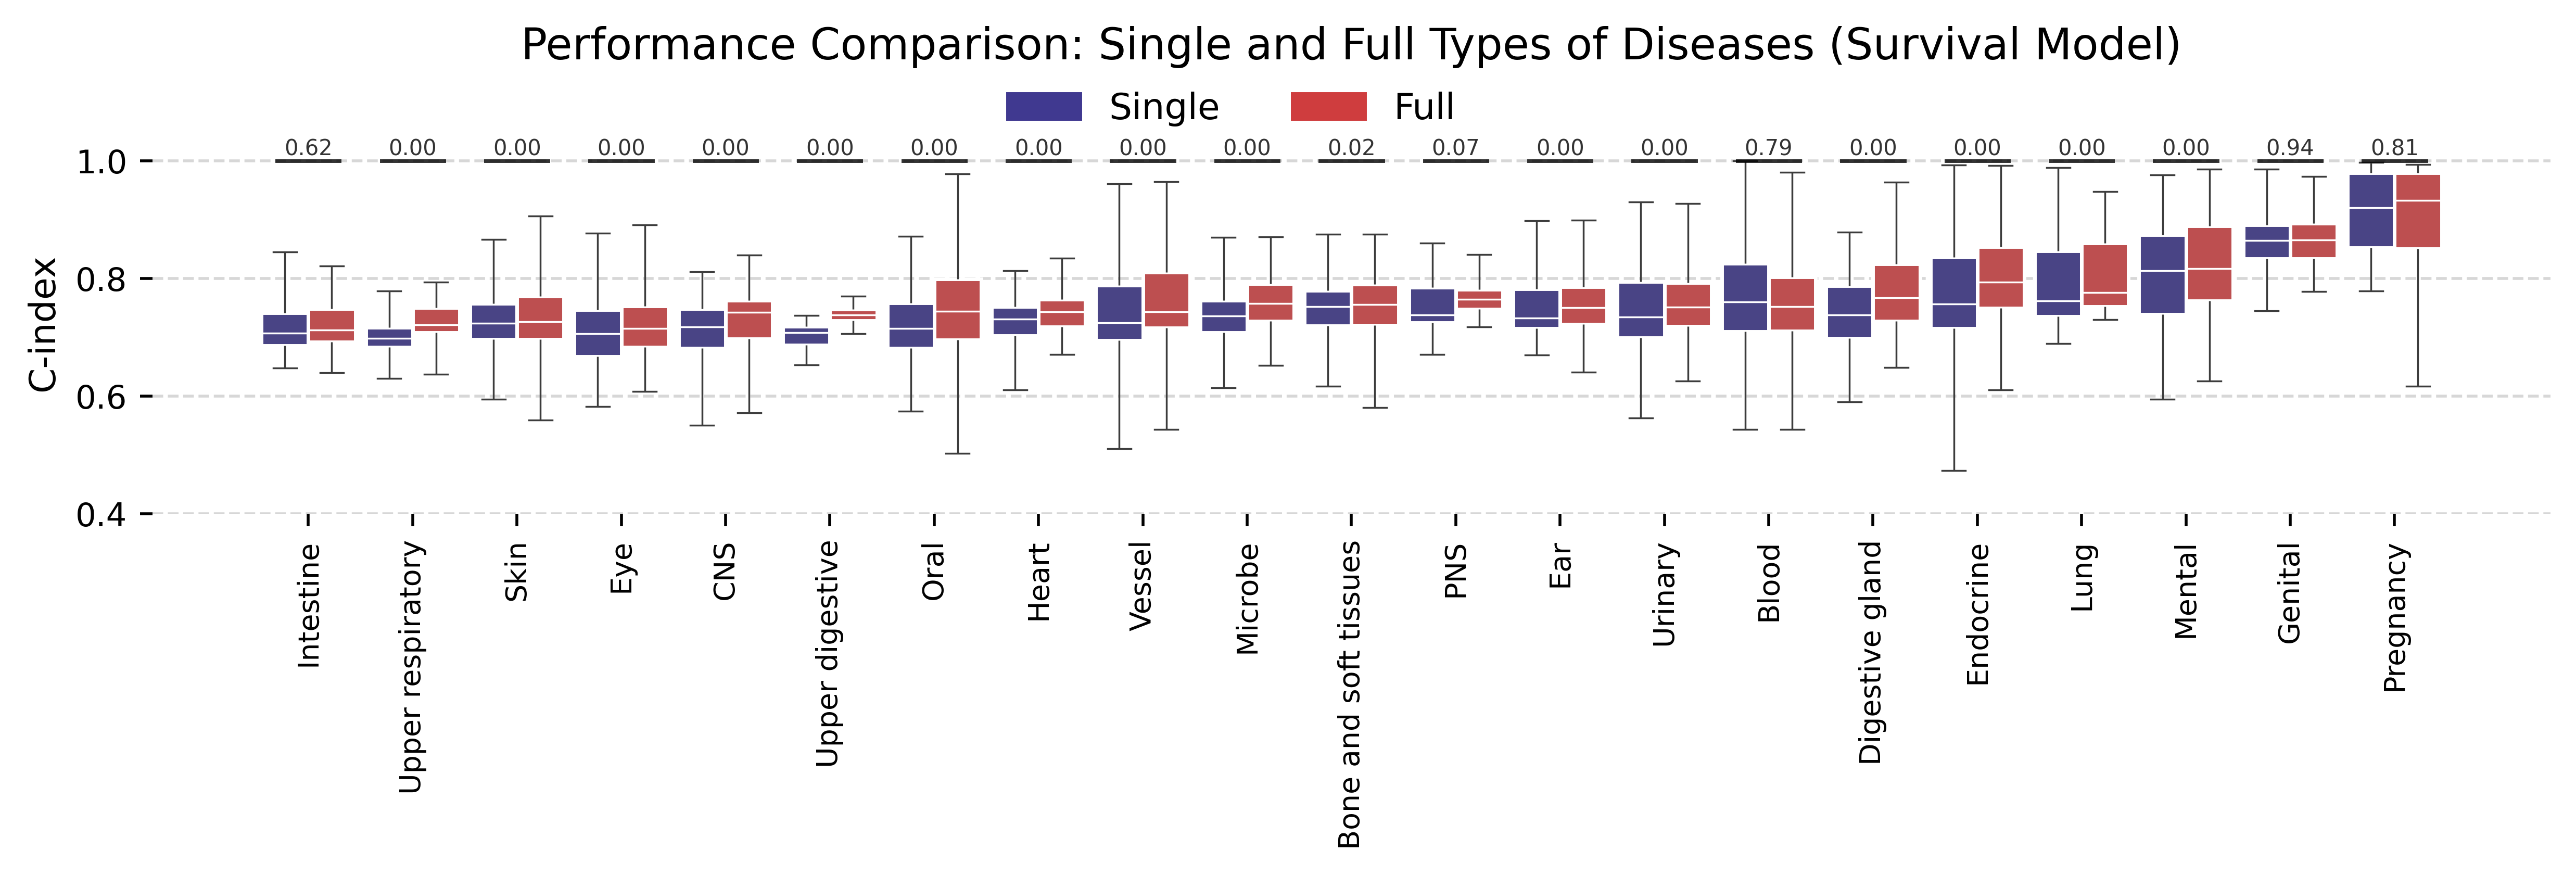

In [7]:
colors = ['#403990','#80A6E2','#FBDD85','#F46F43','#CF3D3E']
cm = LinearSegmentedColormap.from_list('Nature', colors, N=2)
colorlist = []
for i in range(2):
    colorlist.append(cm(i))
color_palette = sns.color_palette(colorlist)
plt.figure(dpi=500, figsize=(10,3.5))
plt.grid(True,linestyle='--',alpha=0.5)
ax=sns.boxplot(y='data',x='group',hue='hue',palette=color_palette,data=drawdata, whis=2, fliersize=0, notch=False,
            showfliers=True, width = 0.9, boxprops={'linewidth': 1, 'linestyle':"-", 'edgecolor':'white'}, whiskerprops={'linestyle': '-', 'linewidth': 0.5},
            capprops={'linewidth': 0.5}, medianprops={'linewidth': 0.5, 'color':'white'}, gap=0)
plt.ylim(0.4,1.05)
plt.xlabel("")
plt.ylabel("C-index", fontsize=10)
plt.xticks(np.arange(len(keywords)), keywords, fontsize=8,rotation=90)
plt.yticks(fontsize=9)
title = 'Performance Comparison: Single and Full Types of Diseases (Survival Model)'
plt.title(title, pad=20, fontsize=12)
for i, key in enumerate(keywords):
    p = pvalue[i]
    x_pos = i
    y_pos = 1
    plt.text(x_pos, y_pos+0.01, f'{p:.2f}', ha='center', fontsize=6,alpha=0.8)
    plt.plot((x_pos-0.3,x_pos+0.3), (y_pos,y_pos),color='black', linewidth=1,alpha=0.8)
legend_names=['Single','Full']
legend_handles=[]
for i in range(2):
    legend_handles.append(Patch(color=colorlist[i], label=legend_names[i]))
legend = plt.legend(handles=legend_handles, ncol=4,fontsize=10,loc='upper center',bbox_to_anchor=(0.45, 1.19))
legend.get_frame().set_linewidth(0)
legend.get_frame().set_facecolor('none') 
plt.tight_layout()
axi = plt.gca()
axi.spines['top'].set_color('none')
axi.spines['bottom'].set_color('none')
axi.spines['left'].set_color('none')
axi.spines['right'].set_color('none')
plt.savefig(temppath + title+'.pdf', format='pdf',bbox_inches="tight")
plt.show()

In [8]:
m = {}
for key in keywords:
    m[key] = []
    m[key].append(np.nanmedian(singledictionary[key]))
    m[key].append(np.nanmedian(alldictionary[key]))
json_file_path = numericpath + title+'.json'
with open(json_file_path, 'w', encoding='utf-8') as f:
    json.dump(m, f, ensure_ascii=False, indent=4)